# Imports and parameters

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import tqdm
import torch
import shutil
import sys

from diffusers import DDIMScheduler, DiffusionPipeline, StableDiffusionPipeline, DPMSolverMultistepScheduler
from pathlib import Path
from PIL import Image
from typing import Optional

/Users/robdewit/Documents/text2image/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()

## Parameters

In [78]:
# Model
MODEL_DIRECTORY = 'models'
BASE_MODEL = 'runwayml/stable-diffusion-v1-5'

# LoRA
INPUT_DATA = 'data/external/pokemon'
POKEMON_STATS = 'data/external/pokemon_stats.csv'
TRAIN_DATA = 'data/processed/pokemon'
TARGET_POKEMON_TYPE = 'all'
TARGET_POKEMON_GENERATION = -1
LORA_PATH = f'{MODEL_DIRECTORY}/loras'
LORA_NAME = 'pkmnlora'

# Pokemon of interest
TARGET_POKEMON_TYPE = 'all'
TARGET_POKEMON_GENERATION = -1

# Generation
SEED = 3000
NUM_INFERENCE_STEPS = 35
BATCH_SIZE = 4
PROMPT = 'a (pkmnlora:1.5) (pokemon), drawn concept art, facing camera, (solid white background:1.2)'
NEGATIVE_PROMPT = 'human, people, person, 3d, computer graphic, black and white, (painting by bad-artist:0.9), watermark, text, error, blurry, jpeg artifacts, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, artist name, (worst quality, low quality:1.4), bad anatomy'
OUTPUT_DIRECTORY = 'outputs'

# Get subset of relevant Pokémon

In [4]:
pokemon = pd.read_csv(PROJECT_ROOT / POKEMON_STATS)
pokemon = pokemon[["pokedex_number", "name", "type1", "type2", "generation"]]

pokemon.head()

if not TARGET_POKEMON_TYPE.lower() in ['all', 'none', '']:
    subset_1 = pokemon.loc[pokemon['type1'] == TARGET_POKEMON_TYPE]
    subset_2 = pokemon.loc[pokemon['type2'] == TARGET_POKEMON_TYPE]
    
    subset = pd.concat([subset_1, subset_2]).sort_values('pokedex_number')
else:
    subset = pokemon
    
if not TARGET_POKEMON_GENERATION in [-1, 0]:
    subset = subset.loc[subset['generation'] == TARGET_POKEMON_GENERATION]
else:
    None
    
subset.head()

,pokedex_number,name,type1,type2,generation
0,1,Bulbasaur,grass,poison,1
1,2,Ivysaur,grass,poison,1
2,3,Venusaur,grass,poison,1
3,4,Charmander,fire,NaN,1
4,5,Charmeleon,fire,NaN,1


# Resize training images to desired resolution

In [5]:
# Create directory and clear if it already exists
if not os.path.exists(PROJECT_ROOT / TRAIN_DATA):
    os.mkdir(PROJECT_ROOT / TRAIN_DATA)
else:
    shutil.rmtree(PROJECT_ROOT / TRAIN_DATA)
    os.mkdir(PROJECT_ROOT / TRAIN_DATA)
          
# Resize training images and save to processed directory
for image_name in os.listdir(PROJECT_ROOT/INPUT_DATA):
    
    # Only keep sprites of our defined subset (e.g. water type generation 1)
    pokedex_number = int(image_name.split('.')[0])
    
    if pokedex_number in list(subset['pokedex_number']):
        pokemon_sprite = Image.open(PROJECT_ROOT/ INPUT_DATA / image_name)
        pokemon_sprite_resized = pokemon_sprite.resize((512, 512))

        # Add leading zeroes
        while len(image_name) < 8:
            image_name = "0" + image_name

        pokemon_sprite_resized.save(PROJECT_ROOT / TRAIN_DATA / image_name)


# Train LoRA  (bash)

In [6]:
%%bash -s "$PROJECT_ROOT" "$BASE_MODEL" "$TRAIN_DATA" "$LORA_PATH"

export PROJECT_ROOT=$1
export BASE_MODEL=$2
export TRAIN_DATA=$3
export LORA_PATH=$4

# NEED TO RUN THESE ONCE
# git clone --depth 1 --branch v0.14.0 https://github.com/huggingface/diffusers.git $PROJECT_ROOT/diffusers
# pip3.10 install -r "${PROJECT_ROOT}/diffusers/examples/dreambooth/requirements.txt"
# accelerate config default

# --mps needed for Mac M1+
accelerate launch --mps "${PROJECT_ROOT}/diffusers/examples/dreambooth/train_dreambooth_lora.py" \
  --pretrained_model_name_or_path=$BASE_MODEL  \
  --instance_data_dir=$PROJECT_ROOT/$TRAIN_DATA \
  --output_dir=$PROJECT_ROOT/$LORA_PATH \
  --instance_prompt="a pkmnlora pokemon" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=500 \
  --validation_prompt="a pkmnlora pokemon with green eyes" \
  --validation_epochs=50 \
  --report_to="wandb" \
  --seed="0"

/Users/robdewit/Documents/text2image/.venv/lib/python3.10/site-packages/accelerate/accelerator.py:231: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
04/12/2023 13:48:17 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: mps
Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type', 'prediction_type', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'only_cross_attention', 'upcast_attention', 'resnet_time_scale_shift', 'conv_in_kernel', 'num_class_embeds', 'projection_class_embeddings_input_dim', 'conv_out_kernel', 'use_linear_projection', 'dual_cross_attention'

Model weights saved in /Users/robdewit/Documents/text2image/models/loras/pytorch_lora_weights.bin

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 14908.66it/s]
{'requires_safety_checker'} was not found in config. Values will be initialized to default values.
{'scaling_factor'} was not found in config. Values will be initialized to default values.
{'prediction_type'} was not found in config. Values will be initialized to default values.
{'only_cross_attention', 'upcast_attention', 'resnet_time_scale_shift', 'conv_in_kernel', 'num_class_embeds', 'projection_class_embeddings_input_dim', 'conv_out_kernel', 'use_linear_projection', 'dual_cross_attention', 'class_embed_type', 'timestep_post_act', 'mid_block_type', 'time_embedding_type', 'time_cond_proj_dim'} was not found in config. Values will be initialized to default values.
{'solver_order', 'algorithm_type', 'dynamic_thresholding_ratio', 'solver_type', 'sample_max_value', 'thresholding', 'lower_order_final'} was not found in con

In [ ]:
# accelerate launch --mps "diffusers/examples/dreambooth/train_dreambooth_lora.py" \
#   --pretrained_model_name_or_path='runwayml/stable-diffusion-v1-5' \
#   --instance_data_dir='data/processed/pokemon' \
#   --output_dir='models/test1' \
#   --instance_prompt="a drawing of a pokemon" \
#   --resolution=512 \
#   --train_batch_size=1 \
#   --gradient_accumulation_steps=1 \
#   --checkpointing_steps=100 \
#   --learning_rate=1e-4 \
#   --lr_scheduler="constant" \
#   --lr_warmup_steps=0 \
#   --max_train_steps=300 \
#   --validation_prompt="a drawing of a pokemon" \
#   --validation_epochs=50 \
#   --seed="0" \
#   --report_to="wandb"

# Set up SD pipeline

In [26]:
pipe = DiffusionPipeline.from_pretrained(BASE_MODEL)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

# These settings work for Apple M1/M2 silicon
# Docs for configuring to your hardware: https://huggingface.co/docs/diffusers/optimization/fp16
pipe.to("mps")

# Recommended if your computer has < 64 GB of RAM
pipe.enable_attention_slicing()

Fetching 15 files: 100%|█████████████████████████████| 15/15 [00:00<00:00, 26083.98it/s]


In [11]:
# Load LoRA on top of base model weights
pipe.unet.load_attn_procs(PROJECT_ROOT/LORA_PATH)

# Generate images

In [79]:
generator = torch.Generator().manual_seed(SEED)

outputs = pipe(prompt=[PROMPT] * BATCH_SIZE
             , negative_prompt=[NEGATIVE_PROMPT] * BATCH_SIZE
             , generator=generator
             , num_inference_steps=NUM_INFERENCE_STEPS)

100%|███████████████████████████████████████████████████| 50/50 [02:36<00:00,  3.13s/it]


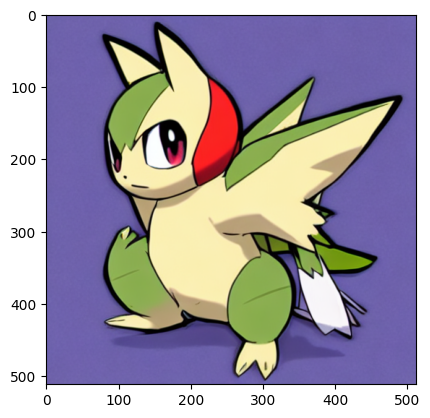

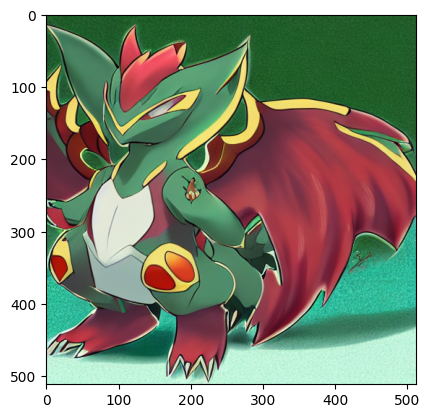

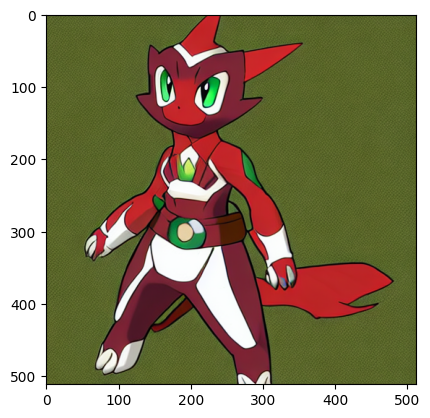

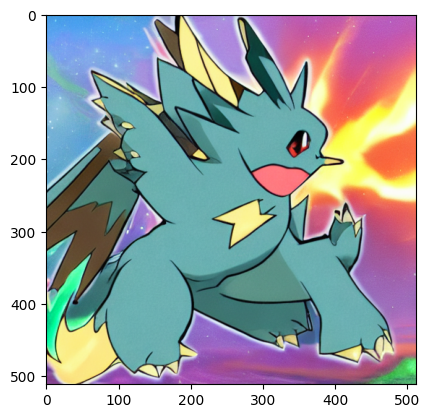

In [80]:
for image in outputs.images:
    imgplot = plt.imshow(image)
    plt.show(image)